### This script selects valid structures, eliminates outliers, and apply a clustering method with energies

In [1]:
from ase import Atoms, Atom
from ase.visualize import view
from ase.io import read, write
from ase.build import mx2, add_adsorbate
from ase.constraints import FixAtoms
from ase.build import surface
from ase.data.colors import jmol_colors
from IPython import display
from sklearn.metrics.pairwise import pairwise_distances_argmin, pairwise_distances_argmin_min
from sklearn.ensemble import IsolationForest



import os
from ase.collections import g2
from ase.build import molecule

###scikitlearn
from sklearn.cluster import KMeans
from sklearn import preprocessing




##plot
import pandas as pd
import matplotlib.pyplot as plt 

## Reading an output and identifying the bonded atoms from the molecule's guest.

In [2]:

for estr in range(1): #2082
    ##Leyendo contcar de todas las estructuras
    mol_mof = read('output/conf_{}/CONTCAR'.format(estr))
    indices_molmof= [[24,81], [81,82], [82,83], [83,84],[84,85],[85,86],[86,87],[87,82],
                [24,41],[81,43],[81,42],[83,44],[84,45],[85,46],[86,47], [87,48]]

    dis_molmof = []
    for i in indices_molmof:
        distance = mol_mof.get_distance(i[0], i[1], mic=True)
        dis_molmof.append(distance)
    print(dis_molmof)

[6.071142874672259, 4.06684031599587, 1.3931903665371452, 1.3930294181933442, 1.393026580096683, 1.3930283756776094, 1.3930332730146529, 1.3931777985903488, 0.9700044252424267, 1.0700054350655857, 6.250815925380133, 1.0320017903113903, 1.0320020147529256, 1.0320012112560963, 1.032002731934844, 6.5524000465613215]


### Searching MOF- guest structures with complete guest.

In [ ]:
##Funcion que verifica que todos los elemntos de una lsita sean True
def todos_verdaderos(lista):
    return all(lista)



###Reading and obtaining bond distances from the isolated molecule (guest).
molais = read('abz_mol.xyz')
indices_molais = [[0,1], [1,2], [2,3], [3,4],[4,5],[5,6],[6,7],[7,2],
                 [0,8], [1,10], [1,9], [3,11],[4,12], [5,13],
                [6,14],[7,15]]
dis_molais = []
for m in indices_molais:
    distance = molais.get_distance(m[0], m[1], mic=True)
    dis_molais.append(distance)    

##Obtaining bond distances from the molecule guest interacting with the MOF for every configuration.
file = open('myfile.dat', 'w')
good_str = []
for estr in range(2183): #2082
    ##Leyendo contcar de todas las estructuras
    mol_mof = read('output/conf_{}/CONTCAR'.format(estr))
    indices_molmof= [[24,81], [81,82], [82,83], [83,84],[84,85],[85,86],[86,87],[87,82],
                [24,41],[81,43],[81,42],[83,44],[84,45],[85,46],[86,47], [87,48]]

    dis_molmof = []
    for i in indices_molmof:
        distance = mol_mof.get_distance(i[0], i[1], mic=True)
        dis_molmof.append(distance)


    ### Comparing bond distances from the molecule guest in the MOF with bond distances from the isolated molecule. If the distances 
    ###are in the range (parameter), the structure is saved in a list of valid structures. 
     
    mi_lista = []
    for b,c in zip(dis_molmof, dis_molais):
        parameter = c-0.2 < b < c+0.2
        mi_lista.append(parameter)
    #print(estr, mi_lista)
    
    
    if todos_verdaderos(mi_lista):
        file.write(str(estr)) 
        file.write("\n")
        good_str.append(estr)
        #print("Todos los elementos en la lista son verdaderos.")
    else:
        #print("Al menos uno de los elementos en la lista es falso.")
        pass
file.close()     
print(good_str)

In [4]:
len(good_str)

779

### Obtaining energy from every configuration tested  ##

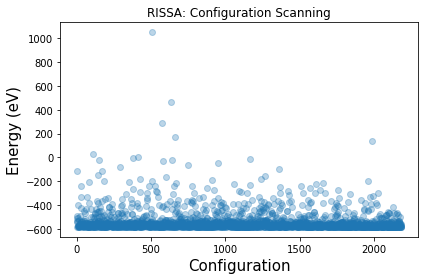

In [3]:
directory = '/output'   ### directory with CONTCAR structures
os.chdir(directory)
main = os.getcwd()
#print('this is main directory: ', main)


energies = []
ns = []
#for n in good_str:
for n in range(2183):    
    dir = main + '/' + 'conf_{}'.format(n) 
    os.chdir(dir)
    atoms = read('OUTCAR', format='vasp-out', index=-1)
    energy = atoms.get_potential_energy()
    ns.append(n)
    energies.append(energy)
    #print(n, energy)

    
### Plotting data


fig, ax = plt.subplots()
ax.scatter(ns, energies,  alpha=0.3)

ax.set_xlabel('Configuration', fontsize=15)
ax.set_ylabel('Energy (eV)', fontsize=15)
ax.set_title('RISSA: Configuration Scanning')


fig.tight_layout()

plt.show()    

#### Creating a dataframe with the energies of valid structures

In [6]:
#haciendo un df para obtener las energias mas bajas con sus respectivos indices
df = pd.DataFrame(energies, columns=['energy'] )

#use nsmallest to select the three rows having the smallest values in column “energy”.

df.nsmallest(20, 'energy')

,energy
1869,-583.396345
43,-583.337438
901,-583.153742
2116,-583.116603
1874,-583.049411
1334,-583.009609
1222,-582.989396
1640,-582.987769
1758,-582.975292
494,-582.883436


### Clustering method

In [7]:
##Normalizing data (0-1)

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [8]:
df_scaled.head()

,energy
0,0.004264
1,0.008884
2,0.006578
3,0.021053
4,0.000607


In [9]:
### Applying clustering method ###
clusters = 5
for nc in range(1,5):
        km = KMeans(n_clusters=nc,
                       init='k-means++',
                       n_init=10,
                       max_iter=300,
                       random_state=0)
        km.fit(df_scaled)

        # We want to have the same colors for the same cluster from the MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per closest one.
        k_means_cluster_centers = km.cluster_centers_  #centros de los clusters 
        k_means_labels = pairwise_distances_argmin(df_scaled, k_means_cluster_centers) #Compute minimum distances between one point and a set of points
        closest, dist = pairwise_distances_argmin_min(k_means_cluster_centers, df_scaled) #return data indexes closest to centroides and the distances
        a = k_means_labels.tolist()
        

Int64Index([40, 43, 118, 137, 173, 231, 255, 278, 411, 526, 566, 607], dtype='int64')
[0.48047088]
Int64Index([451], dtype='int64')
[1.]
Int64Index([ 15,  30,  45,  50,  58, 139, 146, 283, 320, 339, 357, 442, 454,
            490, 502, 513, 527, 604, 610, 686],
           dtype='int64')
[0.17531343]


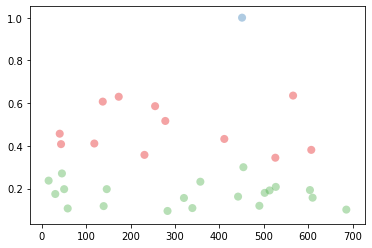

In [10]:
##plotting data and clusters
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']
#colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00','#ffff33']
fig =  plt.figure()

for k, col in zip(range(1,4), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    #print(my_members.shape)
    print(df_scaled.index[my_members])
    #print(df_scaled.loc[my_members, 'energy'])
    plt.scatter(df_scaled.index[my_members], df_scaled.loc[my_members, 'energy'], c=col, s=65, label=k+1, edgecolor='none', alpha=0.4)
    #plt.scatter(df_scaled.index[my_members].mean(), df_scaled.loc[my_members, 'energy'].mean(), c=col, marker='*', s=150, edgecolor='k')
    print(cluster_center)
plt.show()

### Identifying and eliminating outliers


In [11]:
def_anom = df_scaled
def_anom.head()

,energy
0,0.004264
1,0.008884
2,0.006578
3,0.021053
4,0.000607


### Isolation Forest method

In [ ]:
# Definition and training of the IsolationForest Model for Anomaly detection
# Pleasenote that this is a unsupervised model and hence thereis no objective way to train it
# The following is a Naive set of parammeters
# ==============================================================================
modelo_isof = IsolationForest(
                n_estimators  = 1000,
                max_samples   ='auto',
                contamination = 0.1,
                random_state  = 0)

modelo_isof.fit(def_anom)


In [ ]:
# Prediction from the Anomaly Detection Model
# ==============================================================================
def_anom['anomaly'] = modelo_isof.predict(def_anom)    # Anomaly prediction| 1:Ok | -1:Anomaly


In [14]:
# Number of anomalies predicted by the number of rings in the molecule
# ==============================================================================
anomaly       = def_anom.loc[def_anom['anomaly']==-1]
anomaly_index = list(anomaly.index)
#anomaly_index

In [15]:
# Dataset free of anomalies
# ==============================================================================
df_clean = def_anom.loc[def_anom['anomaly']==1]
df_clean_index = list(df_clean.index)
df_clean

,energy,anomaly
0,0.004264,1
1,0.008884,1
2,0.006578,1
3,0.021053,1
4,0.000607,1
...,...,...
774,0.000484,1
775,0.001268,1
776,0.002522,1
777,0.004905,1


In [16]:
df_clean.nsmallest(5, 'energy')

,energy,anomaly
340,0.000000,1
5,0.000020,1
730,0.000025,1
680,0.000029,1
355,0.000040,1


#### New clustering without outliers

In [ ]:
clusters = 5
for nc in range(1,5):
        km = KMeans(n_clusters=nc,
                       init='k-means++',
                       n_init=10,
                       max_iter=300,
                       random_state=0)
        km.fit(df_clean)

        # We want to have the same colors for the same cluster from the MiniBatchKMeans and the KMeans algorithm. Let's pair the cluster centers per closest one.
        k_means_cluster_centers = km.cluster_centers_  #centros de los clusters 
        k_means_labels = pairwise_distances_argmin(df_clean, k_means_cluster_centers) #Compute minimum distances between one point and a set of points
        closest, dist = pairwise_distances_argmin_min(k_means_cluster_centers, df_clean) #return data indexes closest to centroides and the distances
        a = k_means_labels.tolist()


In [ ]:
##plotting data and clusters
colors = ['#e41a1c','#377eb8','#4daf4a','#984ea3','#ff7f00']

clusteres = []
fig =  plt.figure()

for k, col in zip(range(1,4), colors):
    cumulo = []
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    print(df_clean.index[my_members])
    plt.scatter(df_clean.index[my_members], df_clean.loc[my_members, 'energy'], c=col, s=65, label=k+1, edgecolor='none', alpha=0.4)
    #plt.scatter(df_clean.index[my_members].mean(), df_clean.loc[my_members, 'energy'].mean(), c=col, marker='*', s=150, edgecolor='k')
    clusteres.append(df_clean.index[my_members])
plt.show()

In [ ]:
for j in range(len(clusteres)):
    indice = []
    energia = []
    for i in range(len(clusteres[j])):
        indice.append(clusteres[j][i])
        energia.append(df.loc[clusteres[j][i], 'energy'])
    dfclus = pd.DataFrame({'indice': indice, 'energia': energia}, columns=['indice', 'energia'])
    lowest_energy = dfclus.nsmallest(5, 'energia')   
    print('The cluster has the next structure with the lowest energy')
    print(j, lowest_energy)
    print('-----------------------')

print("""Ignore the first index. The correct index is the second, who is under indice word.""")    